In [410]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import zscore
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [411]:
ar = pd.read_csv('data/application_record.zip', compression='zip')
cr = pd.read_csv('data/credit_record.zip', compression='zip')

# Предобработка данных

In [412]:
ar.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [413]:
cr.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Очистка данных

In [414]:
# информация о месяце просрочки не понадобится
cr.drop('MONTHS_BALANCE', axis=1, inplace=True)

In [415]:
# C, X, 0 - отсутствие просрочки
# 1-4 - наличие просрочки
cr['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [416]:
cr['STATUS'] = cr['STATUS'].replace({'C' : 0, 'X' : 0})
cr['STATUS'] = cr['STATUS'].astype(int)
cr['STATUS'] = cr['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
cr['STATUS'].value_counts() 

0    1034381
1      14194
Name: STATUS, dtype: int64

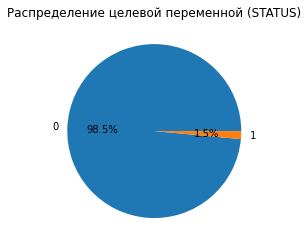

In [417]:
df['STATUS'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Распределение целевой переменной (STATUS)')
plt.ylabel('')
plt.show()

In [418]:
df = ar.join(cr.set_index('ID'), on='ID', how='inner')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0


<AxesSubplot:>

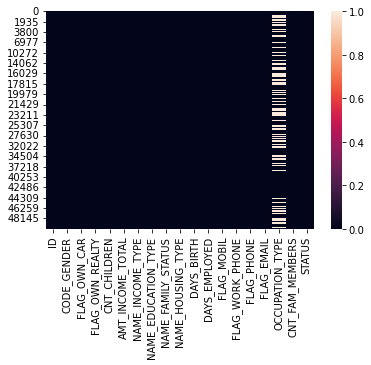

In [419]:
# проверяем наличие пропущенных значений с помощью визуализации
sns.heatmap(df.isnull())

In [421]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

In [422]:
df.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS                 0
dtype: int64

## Кодирование категориальных признаков

In [423]:
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y' : 1, 'N' : 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y' : 1, 'N' : 0})
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'F' : 1, 'M' : 0})

In [424]:
le = LabelEncoder()
df['NAME_INCOME_TYPE'] = le.fit_transform(df['NAME_INCOME_TYPE'])
df['NAME_HOUSING_TYPE'] = le.fit_transform(df['NAME_HOUSING_TYPE'])
df['NAME_EDUCATION_TYPE'] = le.fit_transform(df['NAME_EDUCATION_TYPE']) #
df['NAME_FAMILY_STATUS'] = le.fit_transform(df['NAME_FAMILY_STATUS']) #
df['OCCUPATION_TYPE'] = le.fit_transform(df['OCCUPATION_TYPE']) #

## Проверяем наличие выбросов

<AxesSubplot:xlabel='ID', ylabel='CODE_GENDER'>

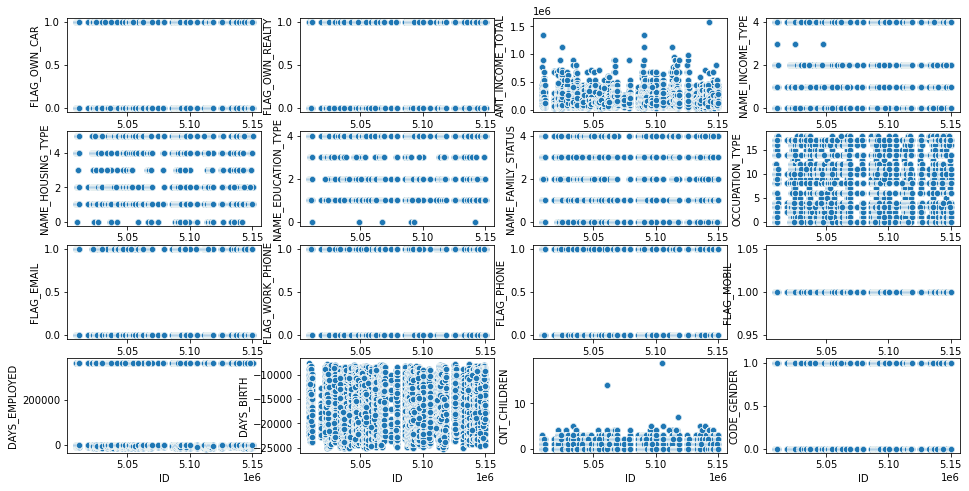

In [426]:
# проверяем наличие выбросов с помощью визуализации

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,8))
sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_CAR'], data=df, ax=ax[0][0])
sns.scatterplot(x=df['ID'], y=df['FLAG_OWN_REALTY'], data=df, ax=ax[0][1])
sns.scatterplot(x=df['ID'], y=df['AMT_INCOME_TOTAL'], data=df, ax=ax[0][2])
sns.scatterplot(x=df['ID'], y=df['NAME_INCOME_TYPE'], data=df, ax=ax[0][3])


sns.scatterplot(x=df['ID'], y=df['NAME_HOUSING_TYPE'], data=df, ax=ax[1][0])
sns.scatterplot(x=df['ID'], y=df['NAME_EDUCATION_TYPE'], data=df, ax=ax[1][1])
sns.scatterplot(x=df['ID'], y=df['NAME_FAMILY_STATUS'], data=df, ax=ax[1][2])
sns.scatterplot(x=df['ID'], y=df['OCCUPATION_TYPE'], data=df, ax=ax[1][3])


sns.scatterplot(x=df['ID'], y=df['FLAG_EMAIL'], data=df, ax=ax[2][0])
sns.scatterplot(x=df['ID'], y=df['FLAG_WORK_PHONE'], data=df, ax=ax[2][1])
sns.scatterplot(x=df['ID'], y=df['FLAG_PHONE'], data=df, ax=ax[2][2])
sns.scatterplot(x=df['ID'], y=df['FLAG_MOBIL'], data=df, ax=ax[2][3])

sns.scatterplot(x=df['ID'], y=df['DAYS_EMPLOYED'], data=df, ax=ax[3][0])
sns.scatterplot(x=df['ID'], y=df['DAYS_BIRTH'], data=df, ax=ax[3][1])
sns.scatterplot(x=df['ID'], y=df['CNT_CHILDREN'], data=df, ax=ax[3][2])
sns.scatterplot(x=df['ID'], y=df['CODE_GENDER'], data=df, ax=ax[3][3])

In [427]:
variances = df.select_dtypes(include=['number']).var()
print("Дисперсия признаков:\n", variances)

Дисперсия признаков:
 ID                     1.747610e+09
CODE_GENDER            2.220618e-01
FLAG_OWN_CAR           2.381958e-01
FLAG_OWN_REALTY        2.245416e-01
CNT_CHILDREN           5.561508e-01
AMT_INCOME_TOTAL       1.032712e+10
NAME_INCOME_TYPE       3.012569e+00
NAME_EDUCATION_TYPE    1.814758e+00
NAME_FAMILY_STATUS     8.636810e-01
NAME_HOUSING_TYPE      8.552111e-01
DAYS_BIRTH             1.684531e+07
DAYS_EMPLOYED          1.862453e+10
FLAG_MOBIL             1.232597e-32
FLAG_WORK_PHONE        1.780784e-01
FLAG_PHONE             2.103853e-01
FLAG_EMAIL             8.327078e-02
OCCUPATION_TYPE        3.153513e+01
CNT_FAM_MEMBERS        8.233380e-01
STATUS                 1.466185e-02
dtype: float64


<AxesSubplot:>

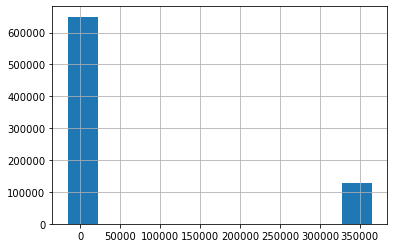

In [428]:
df['DAYS_EMPLOYED'].hist()

In [429]:
df['DAYS_EMPLOYED'].value_counts()

 365243    127972
-1751        1601
-1539        1545
-401         1498
-2531        1319
            ...  
-3294           1
-3891           1
-7049           1
-7765           1
-2848           1
Name: DAYS_EMPLOYED, Length: 3640, dtype: int64

Нереалистичное значение 365 243 - это аномалия. 

In [430]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, 0)

<AxesSubplot:>

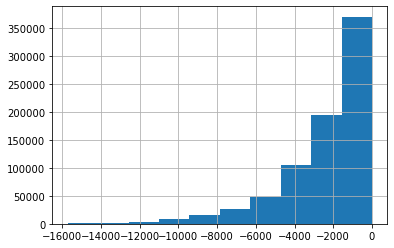

In [431]:
df['DAYS_EMPLOYED'].hist()

Выбросы присутствуют по следующим признакам: AMT_INCOME_TOTAL, CNT_CHILDREN. Вычисляем Z-оценки и удаляем выбросы (|Z| > 3)

In [434]:
df['z_score'] = zscore(df['AMT_INCOME_TOTAL'])
df = df[np.abs(df['z_score']) <= 3]

In [435]:
df['z_score'] = zscore(df['CNT_CHILDREN'])
df = df[np.abs(df['z_score']) <= 3]

In [436]:
df.drop('z_score', axis=1, inplace=True)

In [437]:
# У признака FLAG_MOBIL нулевая дисперсия (это видно и на графике), его можно удалить
df.drop('FLAG_MOBIL', axis=1, inplace=True)

In [438]:
# Посмотрим еще раз дисперсию после удаления выбросов
variances = df.select_dtypes(include=['number']).var()
print("Дисперсия признаков:\n", variances)

Дисперсия признаков:
 ID                     1.746629e+09
CODE_GENDER            2.208974e-01
FLAG_OWN_CAR           2.370269e-01
FLAG_OWN_REALTY        2.254981e-01
CNT_CHILDREN           4.209386e-01
AMT_INCOME_TOTAL       6.800061e+09
NAME_INCOME_TYPE       3.000583e+00
NAME_EDUCATION_TYPE    1.803202e+00
NAME_FAMILY_STATUS     8.745051e-01
NAME_HOUSING_TYPE      8.604081e-01
DAYS_BIRTH             1.701891e+07
DAYS_EMPLOYED          6.017734e+06
FLAG_WORK_PHONE        1.778023e-01
FLAG_PHONE             2.095668e-01
FLAG_EMAIL             8.217775e-02
OCCUPATION_TYPE        3.154154e+01
CNT_FAM_MEMBERS        6.812396e-01
STATUS                 1.453546e-02
dtype: float64


## Проверка корреляции признаков

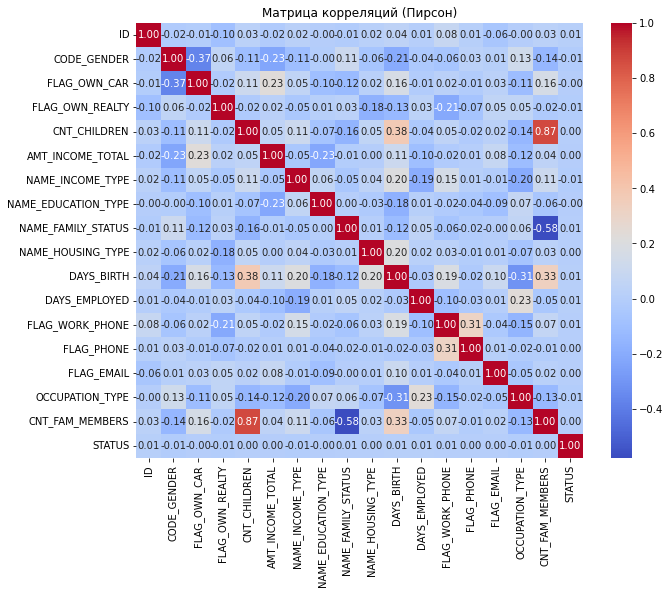

In [439]:
# Вычисление матрицы корреляций
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций (Пирсон)')
plt.show()

Высокая корреляция признаков CNT_FAM_MEMBERS и CNT_CHILDREN. Попробуем дропнуть CNT_FAM_MEMBERS.

In [440]:
df.drop('CNT_FAM_MEMBERS', axis=1, inplace=True) 

# Обучение модели

In [441]:
X = df.loc[:, ~df.columns.isin(['ID', 'STATUS'])]
y = df['STATUS']

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [443]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

In [444]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

Масштабирование применяется только к обучающим данным, а затем тестовые данные масштабируются на основе параметров, полученных из обучающих данных. Этот подход предотвращает утечку данных (data leakage). SMOTE также применяется только к обучающим данным.

In [445]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE()),
        ('model', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    results[name] = cv_scores.mean()
    print(f"{name}: Средний ROC-AUC = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Logistic Regression: Средний ROC-AUC = 0.5685 ± 0.0064
Decision Tree: Средний ROC-AUC = 0.8754 ± 0.0029
Random Forest: Средний ROC-AUC = 0.8766 ± 0.0031
XGBoost: Средний ROC-AUC = 0.8223 ± 0.0039


In [446]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {results[best_model_name]:.4f}")


Лучшая модель: Random Forest с ROC-AUC = 0.8766


In [448]:
best_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('smote', SMOTE(random_state=42)),
                ('model', RandomForestClassifier())])

In [449]:
y_pred = best_pipeline.predict_proba(X_test)[:, 1]

In [450]:
test_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC на тестовой выборке: {test_auc:.4f}")
print(f"Gini: {2 * test_auc - 1}")

ROC-AUC на тестовой выборке: 0.8815
Gini: 0.7630584726529983


In [452]:
y_pred_class = best_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    148965
           1       0.08      0.70      0.15      2231

    accuracy                           0.88    151196
   macro avg       0.54      0.79      0.54    151196
weighted avg       0.98      0.88      0.93    151196



# Интерпретация

In [453]:
importances = best_model.feature_importances_

In [454]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

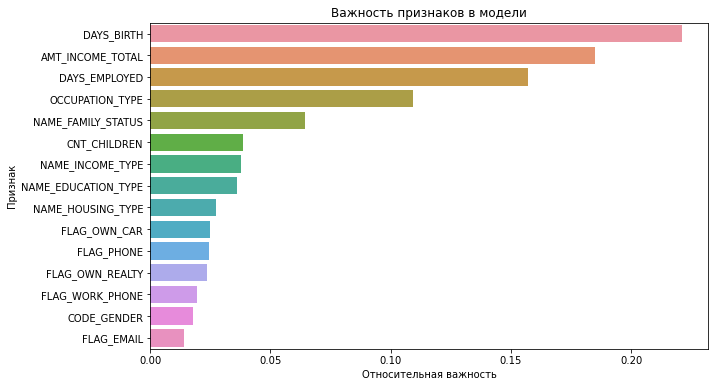

In [455]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature'
)
plt.title('Важность признаков в модели')
plt.xlabel('Относительная важность')
plt.ylabel('Признак')
plt.show()